In [9]:
import pyopenms as oms
import pandas as pd
import sys
sys.path.append(r"..")
import microspot_util as msu
import matplotlib.pyplot as plt
import microspot_util.plots as plots

In [10]:
exp = oms.MSExperiment()
oms.MzMLFile().load("../test_mzml/231004_TestAB_1.mzML", exp)

ft=msu.feature_finding(
    exp=exp,
    mass_error=10,
    noise_threshold=1e5,
    min_fwhm=1,
    max_fwhm=60
)

xics=msu.xic_generator(
    exp=exp,
    ft=ft
)

ft

Progress of 'mass trace detection':
-- done [took 6.63 s (CPU), 6.53 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.17 s (CPU), 0.02 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.16 s (CPU), 0.02 s (Wall)] -- 


,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,
4904849049101935267,3,67.913730,150.768212,64.942854,85.729362,150.768082,151.102859,0.000309,24854486.0
12018183658445670134,3,239.490684,155.440220,199.978920,312.449100,155.439865,155.774811,0.000211,17428608.0
6391682040222117135,3,68.554974,160.112047,63.663474,87.363738,160.112000,160.781265,0.001772,143574000.0
13055611801575658045,3,239.490684,160.112236,182.125662,313.114722,160.112015,160.446945,0.000264,22184716.0
13268104776262119521,1,133.022508,164.092734,126.841506,192.029040,164.092651,165.096222,0.000429,38557404.0
...,...,...,...,...,...,...,...,...,...
4887364709794087146,1,69.675978,1059.556565,66.709224,77.889360,1059.549438,1060.572266,0.000277,22765870.0
15616206937623409474,1,68.554974,1063.554478,66.282102,81.485112,1063.551025,1064.561523,0.000282,17117024.0
17429427170186166862,1,69.675978,1163.538372,66.282102,81.485112,1163.532959,1165.548340,0.000965,53050496.0


In [11]:
# exp = oms.MSExperiment()
# oms.MzMLFile().load("../test_mzml/231004_TestAB_1.mzML", exp)

# exp.sortSpectra(True)

# mass_traces = []
# mtd = oms.MassTraceDetection()
# mtd_params = mtd.getDefaults()
# mtd_params.setValue(
#     "mass_error_ppm", float(10)
# )  # set according to your instrument mass error
# mtd_params.setValue(
#     "noise_threshold_int", float(1e5)
# )  # adjust to noise level in your data
# mtd.setParameters(mtd_params)
# mtd.run(exp, mass_traces, 0)

# mass_traces_split = []
# mass_traces_final = []
# epd = oms.ElutionPeakDetection()
# epd_params = epd.getDefaults()
# epd_params.setValue("width_filtering", "fixed")
# epd_params.setValue("min_fwhm",float(1))
# epd_params.setValue("max_fwhm",float(60))
# epd.setParameters(epd_params)
# epd.detectPeaks(mass_traces, mass_traces_split)

# if epd.getParameters().getValue("width_filtering") == "auto":
#     epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
# else:
#     mass_traces_final = mass_traces_split

# fm = oms.FeatureMap()
# feat_chrom = []
# ffm = oms.FeatureFindingMetabo()
# ffm_params = ffm.getDefaults()
# ffm_params.setValue("isotope_filtering_model", "none")
# ffm_params.setValue(
#     "remove_single_traces", "true"
# )  # set false to keep features with only one mass trace
# ffm_params.setValue("mz_scoring_by_elements", "false")
# ffm_params.setValue("report_convex_hulls", "true")
# ffm.setParameters(ffm_params)
# ffm.run(mass_traces_final, fm, feat_chrom)

# fm.setUniqueIds()
# ft=fm.get_df()

# ft

,peak_idx,RT,width,left_ips,right_ips,RTstart,RTend,norm_intensity,AUC
peak_nr,,,,,,,,,
0,7,68.0,10.123569,2,12,63.0,73.0,1.338950,7.175401
1,178,239.0,4.530202,175,179,236.0,240.0,0.044267,0.093907


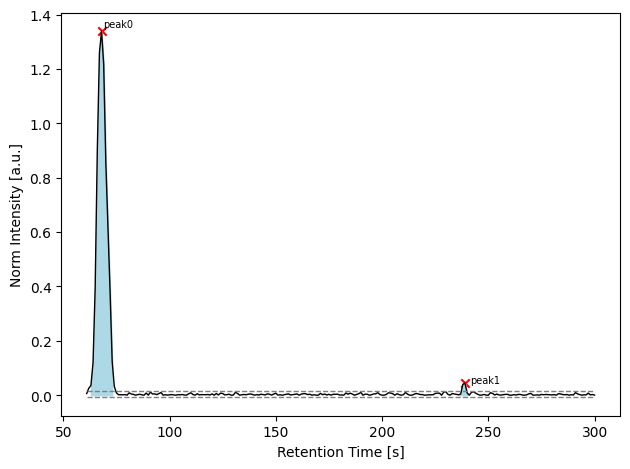

In [13]:
at=pd.read_csv("../output/output_concat.csv",index_col=0)
at.sort_values("RT",inplace=True)

aft=msu.peak_detection(
    df=at,
    baseline_convergence=0.02,
    rel_height=0.95,
    min_dist=10,
    datacolumn_name="norm_intensity"
)

fig,ax=plt.subplots()
plots.plot_activity_chromatogram(
    figure=fig,
    axs=ax,
    spot_df=at,
    peak_df=aft,
    baseline_acceptance=0.02,
    ydata_name="norm_intensity"
)

aft

In [16]:
msu.activity_annotation_features(
    ft=ft,
    aft=aft,
    act_df=at,
    xic_dict=xics,
    rt_tolerance=10,
    ydata_name="norm_intensity"
    )

ft.sort_values("pearson_corr_peak0",ascending=False,inplace=True)


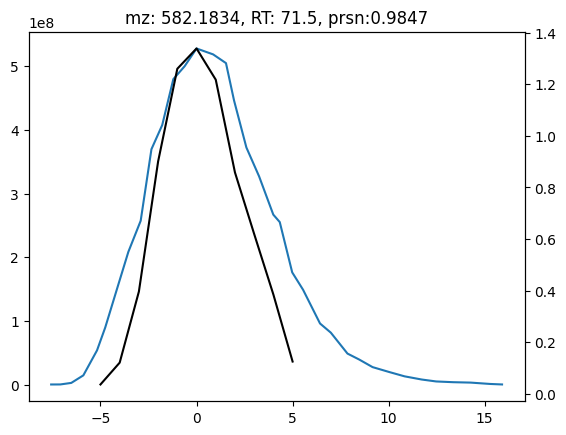

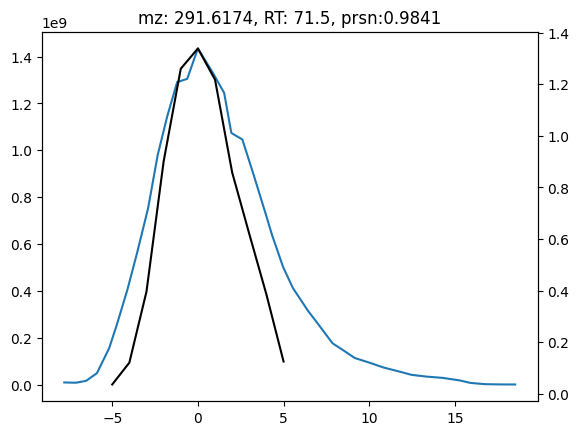

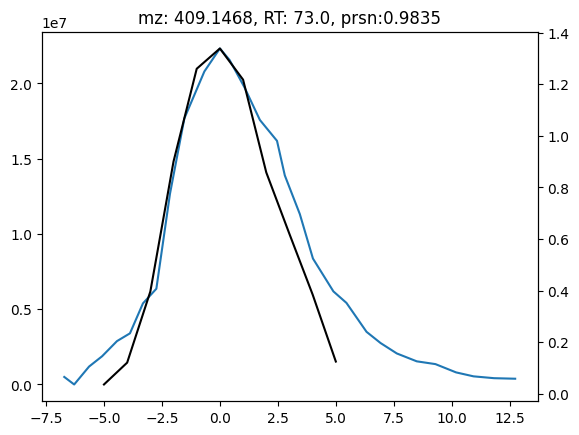

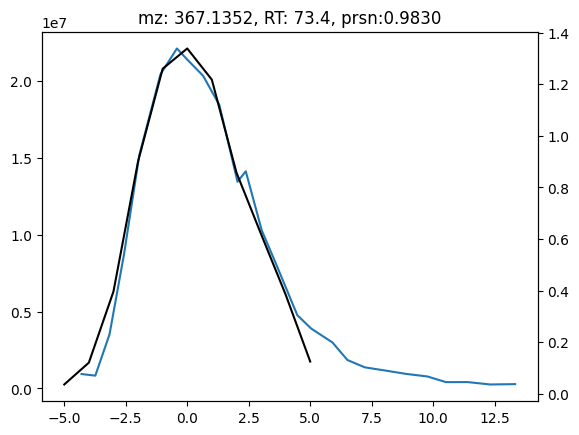

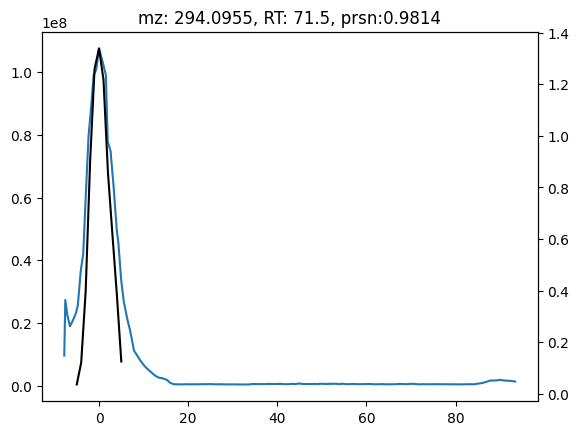

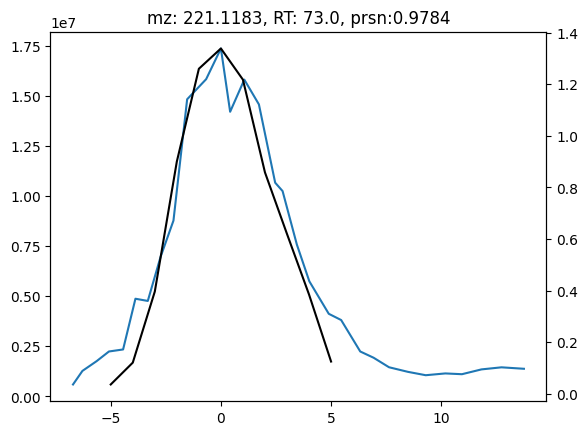

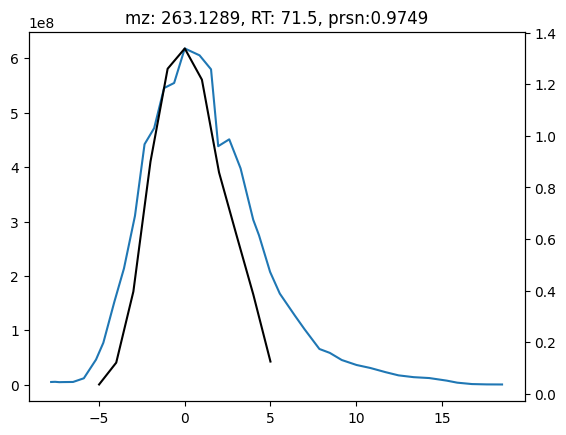

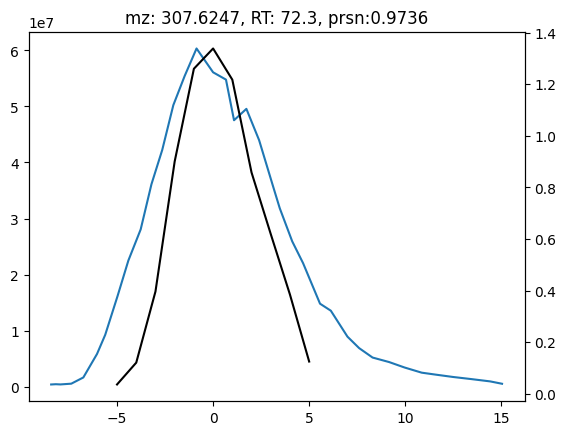

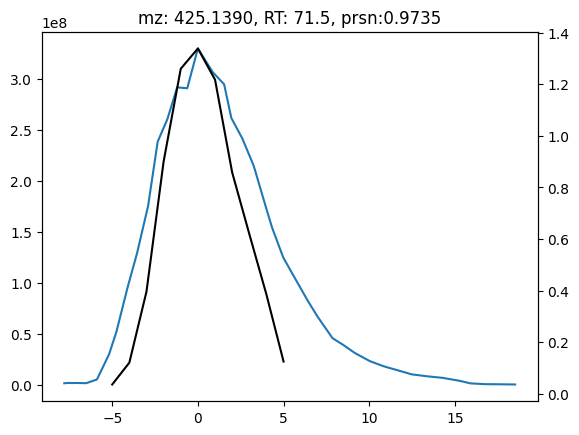

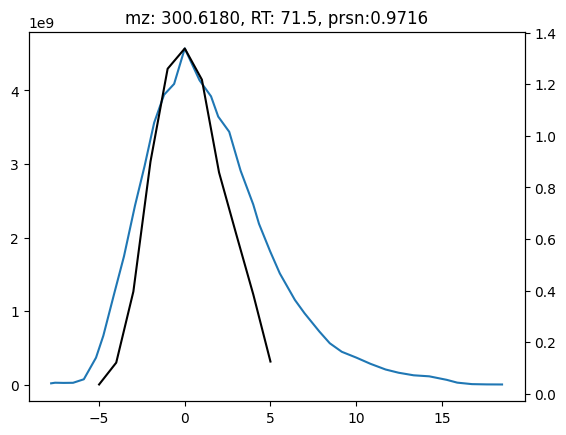

In [21]:
for i in ft.loc[ft["pearson_corr_peak0"]>0].index:
    df=xics[i]
    fig,ax=plt.subplots()
    ax.plot(df.rt-ft.loc[i,"RT"],df.int)
    ax2=ax.twinx()
    ax2.plot(at.loc[aft.loc[0,"left_ips"]:aft.loc[0,"right_ips"],"RT"]-aft.loc[0,"RT"],at.loc[aft.loc[0,"left_ips"]:aft.loc[0,"right_ips"],"norm_intensity"],c="k")

    ax.set(title=f"mz: {ft.loc[i,'mz']:.4f}, RT: {ft.loc[i,'RT']:.1f}, prsn:{ft.loc[i,'pearson_corr_peak0']:.4f}")
